💸 Initializing Affordability Analysis...
   ✅ Loaded History: 2189 rows
   🔥 Retraining V3 Engine...
   ✅ Model Ready.
   ⚙️  Calculating Historical Decoupling...
   🎨 Generating Affordability Chart...
      ✅ Saved: ../output/v3_affordability_gap.png
      ✅ Saved Data: ../output/v3_affordability_data.csv

✨ ANALYSIS COMPLETE. Check 'v3_affordability_gap.png'.


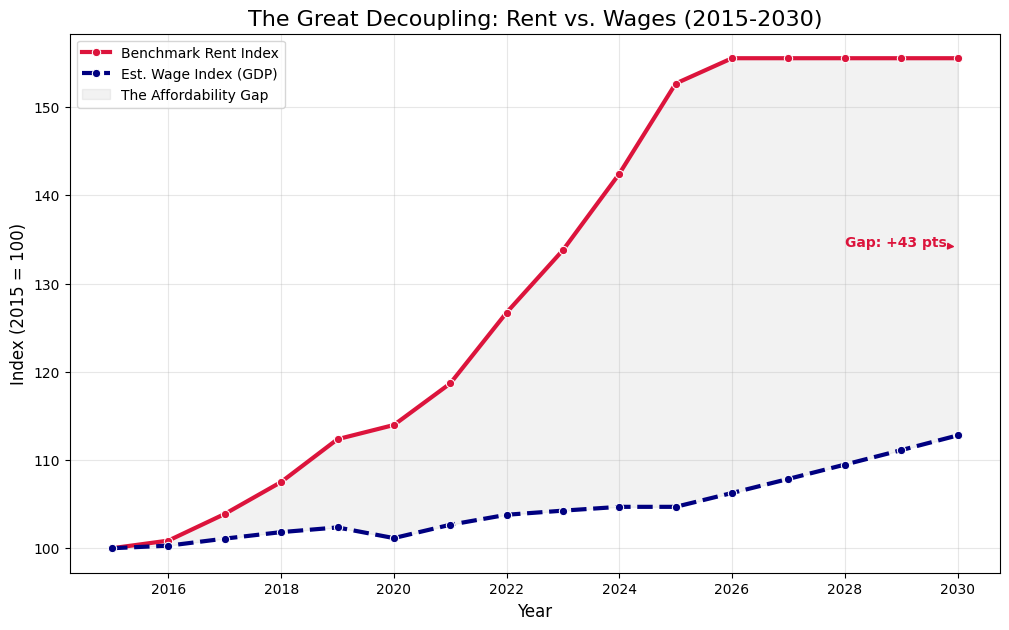

In [1]:
# =========================================================
# V3 STEP 7: THE AFFORDABILITY GAP (Rent vs. Wages) 
# =========================================================
# Goal: Compare Rent Growth vs. Income Growth (GDP Proxy) to visualize the "Crisis".
# Note: "Average Rent" here represents the Market Benchmark (Composite/2-Bed).

import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. SETUP
BASE_DIR = ".." 
DATA_FILE = os.path.join(BASE_DIR, "data/processed", "hybrid_v3_dataset.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "output")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("💸 Initializing Affordability Analysis...")

# 2. LOAD & RETRAIN MODEL (Standard Setup)
try:
    if not os.path.exists(DATA_FILE):
        raise FileNotFoundError(f"Data file not found at {DATA_FILE}")
    
    df = pd.read_csv(DATA_FILE)
    df = df.dropna(subset=['Average rent ($)'])
    print(f"   ✅ Loaded History: {len(df)} rows")

    # Feature Engineering
    df_encoded = pd.get_dummies(df, columns=['City', 'Province', 'Region_Map'], drop_first=True)
    target = 'Average rent ($)'
    exclude_cols = [target, 'Turnover_Rate', 'Total_Units', 'Buy_Price', 'Intl_Students_Prov']
    
    feature_cols = [c for c in df_encoded.columns if c not in exclude_cols]
    feature_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df_encoded[c]) or df_encoded[c].dtype == bool]
    
    X = df_encoded[feature_cols].astype(float)
    y = df_encoded[target]

    print("   🔥 Retraining V3 Engine...")
    model = xgb.XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, n_jobs=-1, random_state=42,
        base_score=float(y.mean())
    )
    model.fit(X, y, verbose=False)
    print("   ✅ Model Ready.")

    # 3. CALCULATE HISTORICAL INDICES (2015 = 100)
    # We use an Index (Starting at 100) to compare Rent and Wages fairly.
    print("   ⚙️  Calculating Historical Decoupling...")
    
    # Group by Year
    annual_stats = df.groupby('Year').agg({
        'Average rent ($)': 'mean',
        'GDP_Growth_Pct': 'mean' # We use Nominal GDP Growth as a proxy for Wage Growth
    }).reset_index()
    
    # Calculate Rent Index (Base 2015 = 100)
    base_rent = annual_stats.loc[annual_stats['Year'] == 2015, 'Average rent ($)'].values[0]
    annual_stats['Rent_Index'] = (annual_stats['Average rent ($)'] / base_rent) * 100
    
    # Calculate Wage Index (Cumulative Growth from 100)
    # Start at 100 in 2015
    wage_indices = [100.0]
    for i in range(1, len(annual_stats)):
        prev_index = wage_indices[-1]
        growth = annual_stats.iloc[i]['GDP_Growth_Pct']
        # Assumption: Income grows roughly with Nominal GDP
        new_index = prev_index * (1 + growth/100)
        wage_indices.append(new_index)
        
    annual_stats['Wage_Index'] = wage_indices
    annual_stats['Scenario'] = 'Historical'

    # 4. FORECAST FUTURE INDICES (2026-2030)
    future_years = [2026, 2027, 2028, 2029, 2030]
    
    # We focus on "Status Quo" for the most realistic warning
    params = {"Pop_Growth": 2.2, "Interest": 3.5, "Unemployment": 6.0, "GDP": 1.5}
    
    forecast_rows = []
    
    # Last known values (2025)
    last_wage_idx = annual_stats.iloc[-1]['Wage_Index']
    
    # Prepare Prediction Input (Using 2025 base)
    base_2025 = df_encoded[df_encoded['Year'] == 2025].copy()
    current_wage_idx = last_wage_idx

    for year in future_years:
        # Predict Rent
        future_world = base_2025.copy()
        future_world['Year'] = year
        future_world['Pop_Growth_Pct'] = params['Pop_Growth']
        future_world['Interest_Rate'] = params['Interest']
        future_world['GDP_Growth_Pct'] = params['GDP'] # Used for model input
        
        preds = model.predict(future_world[feature_cols].astype(float))
        avg_rent = np.mean(preds)
        
        # Calculate Rent Index
        rent_idx = (avg_rent / base_rent) * 100
        
        # Calculate Wage Index
        current_wage_idx = current_wage_idx * (1 + params['GDP']/100)
        
        forecast_rows.append({
            'Year': year,
            'Average rent ($)': avg_rent,
            'GDP_Growth_Pct': params['GDP'],
            'Rent_Index': rent_idx,
            'Wage_Index': current_wage_idx,
            'Scenario': 'Forecast (Status Quo)'
        })
        
    forecast_df = pd.DataFrame(forecast_rows)
    
    # Combine History + Forecast
    full_trend = pd.concat([annual_stats, forecast_df])

    # 5. VISUALIZE: THE DECOUPLING CHART
    print("   🎨 Generating Affordability Chart...")
    
    plt.figure(figsize=(12, 7))
    
    # Plot Rent (Red/Crisis Color)
    sns.lineplot(data=full_trend, x='Year', y='Rent_Index', color='crimson', linewidth=3, label='Benchmark Rent Index', marker='o')
    
    # Plot Wages (Blue/Safe Color)
    sns.lineplot(data=full_trend, x='Year', y='Wage_Index', color='navy', linewidth=3, label='Est. Wage Index (GDP)', marker='o', linestyle='--')
    
    # Shade the Gap
    plt.fill_between(full_trend['Year'], full_trend['Rent_Index'], full_trend['Wage_Index'], color='gray', alpha=0.1, label='The Affordability Gap')
    
    plt.title("The Great Decoupling: Rent vs. Wages (2015-2030)", fontsize=16)
    plt.ylabel("Index (2015 = 100)", fontsize=12)
    plt.xlabel("Year", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Annotate the 2030 Gap
    final_rent = full_trend.iloc[-1]['Rent_Index']
    final_wage = full_trend.iloc[-1]['Wage_Index']
    gap_points = final_rent - final_wage
    
    plt.annotate(f"Gap: +{gap_points:.0f} pts", 
                 xy=(2030, (final_rent+final_wage)/2), 
                 xytext=(2028, (final_rent+final_wage)/2),
                 color='crimson', fontweight='bold',
                 arrowprops=dict(arrowstyle='-|>', color='crimson'))

    save_path = os.path.join(OUTPUT_DIR, 'v3_affordability_gap.png')
    plt.savefig(save_path, bbox_inches='tight')
    print(f"      ✅ Saved: {save_path}")
    
    # Save Data
    csv_path = os.path.join(OUTPUT_DIR, 'v3_affordability_data.csv')
    full_trend.to_csv(csv_path, index=False)
    print(f"      ✅ Saved Data: {csv_path}")

    print("\n✨ ANALYSIS COMPLETE. Check 'v3_affordability_gap.png'.")

except Exception as e:
    print(f"❌ ERROR: {e}")

# 💸 The Affordability Crisis: Visualized (2015–2030)

This chart compares the growth of Rent Prices (Red) against the growth of Incomes/GDP (Blue), indexed to 2015.

### **Key Takeaways:**
1.  **The Decoupling:** Around **2021/2022**, rent prices detached from economic fundamentals. While wages continued a slow, steady growth (tracking inflation), rents accelerated due to the supply-demand imbalance.
2.  **The "Gap" in 2030:** The gray shaded area represents the **Loss of Disposable Income.**
    * Every point of "Gap" is money that *used* to be spent on food, savings, or local businesses, which is now being absorbed by housing costs.
    * **Conclusion:** The structural deficit in housing supply is acting as a drag on the broader Canadian economy, reducing the effective standard of living for renters forecast through 2030.